# Over view
Baseとなるモデルを作成する
- model:Efficientnet 3D ver  
ref:https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type

### Contents
工事中

# Import dependancies

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Config

In [2]:
data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
pytorch3dpath = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"

mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 128 
#DUBUGのため、一旦１２８→１０に
sys.path.append(pytorch3dpath)
from efficientnet_pytorch_3d import EfficientNet3D

# Functions

### 1. load images

(256, 256)
(1, 256, 256, 128)


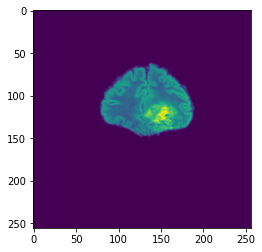

In [3]:
def load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    if rotate>0:
        rot_choices = [0,
                       cv2.ROTATE_90_CLOCKWISE, 
                       cv2.ROTATE_90_COUNTERCLOCKWISE,
                       cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
    data = cv2.resize(data, (img_size,img_size))
    # アウトプットは　H　* W 
    return data

def load_dicom_images_3d(scan_id, 
                         num_imgs=NUM_IMAGES, 
                         img_size=SIZE, 
                         mri_type='FLAIR',
                         split='train',
                         rotate=0):
    # mri_type フォルダ内の画像pathを昇順？にソートして取得
    files = sorted(glob.glob(f'{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm'),
                   key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    #　数字の昇順にsortされると思うが、なぜこれでsortできるかわからない...
    # 数字を返すべきところでfile pathを返しているように思う
    
    # ---------3D配列生成----------
    middle = len(files)//2
    middle_num_imgs = num_imgs//2
    p1 = max(0,middle - middle_num_imgs)
    p2 = min(len(files),middle + middle_num_imgs)
    
    # 総画像の中央から必要枚数分抜き出す
    # D * H *W * Cから　H * W * D に
    img3d = np.stack([load_dicom_image(f,rotate=rotate)for f in files[p1:p2]]).transpose(1,2,0)
    
    # 総画像が必要枚数（num_imgs)無かった場合,空の配列で補完
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d, n_zero),axis = -1)
    
    #0-1で正規化    
    img3d = img3d - np.min(img3d)
    img3d = img3d / np.max(img3d)
    
    # チャネルの次元を加えてあげてreturn(モノクロ画像なので一次元)
    return np.expand_dims(img3d,0)

    
#　症例00000に対してテスト
test_2d = load_dicom_image(glob.glob(f'{data_directory}/train/00000/FLAIR/*.dcm')[0])
print(test_2d.shape)
plt.imshow(test_2d)
test_3d = load_dicom_images_3d('00000')
print(test_3d.shape)


### 2.set seed

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        
set_seed(42)

# Training

## 1. train/test splits 

In [5]:
train_df = pd.read_csv(f'{data_directory}/train_labels.csv')

df_train, df_valid = sk_model_selection.train_test_split(
    train_df,
    test_size = 0.2,
    random_state = 42,
    #陰性、陽性の比率がtrain と　testで等しくなる用にsplit
    stratify = train_df['MGMT_value']
)

## 2. define Dataset class 

In [6]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train", augment=False):
        # paths: pd.sereis(index(patientid),path)
        # target: 正解ラベル
        
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            # idは５桁なのでゼロバディングする
            
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0

            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", rotate=rotation)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


## Define model

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name(
            'efficientnet-b0',
            override_params = {'num_classes':2}, 
            in_channels = 1)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features = n_features,out_features=1,bias=True)
        
    def forward(self,x):
        out = self.net(x)
        return out

## Define Trainer:

In [8]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            # if True:
            # if self.best_valid_score < valid_auc: 
            if self.best_valid_score > valid_loss: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_loss, self.lastmodel
                )
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            # patience = epoch数になっているのがよくわからない
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()
                #????ここだけﾜｶﾗﾝ
            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)


# Train models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values,
        augment=True
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=4,
        shuffle=True,
        num_workers=8,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )

    model = Model()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        # DEBUGのため、一旦3で回す
        3, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        10,
    )
    
    return trainer.lastmodel

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

(468, 3) (117, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,FLAIR
161,240,1,FLAIR
508,740,1,FLAIR
495,725,1,FLAIR
298,432,0,FLAIR


EPOCH: 1
[Epoch Train: 1] loss: 0.7820, time: 421.00 s            
[Epoch Valid: 1] loss: 0.7195, auc: 0.5193, time: 67.00 s
auc improved from inf to 0.7195. Saved model to 'FLAIR-e1-loss0.719-auc0.519.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7066, time: 421.00 s            
[Epoch Valid: 2] loss: 0.7093, auc: 0.5957, time: 66.00 s
auc improved from 0.7195 to 0.7093. Saved model to 'FLAIR-e2-loss0.709-auc0.596.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.7062, time: 420.00 s            
[Epoch Valid: 3] loss: 0.6928, auc: 0.5325, time: 67.00 s
auc improved from 0.7093 to 0.6928. Saved model to 'FLAIR-e3-loss0.693-auc0.532.pth'
(468, 3) (117, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,T1w
161,240,1,T1w
508,740,1,T1w
495,725,1,T1w
298,432,0,T1w


EPOCH: 1
[Epoch Train: 1] loss: 0.7648, time: 408.00 s            
[Epoch Valid: 1] loss: 0.7055, auc: 0.4641, time: 55.00 s
auc improved from inf to 0.7055. Saved model to 'T1w-e1-loss0.705-auc0.464.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7123, time: 403.00 s            
[Epoch Valid: 2] loss: 0.7030, auc: 0.4166, time: 56.00 s
auc improved from 0.7055 to 0.7030. Saved model to 'T1w-e2-loss0.703-auc0.417.pth'
EPOCH: 3
[Epoch Train: 3] loss: 0.7079, time: 404.00 s            
[Epoch Valid: 3] loss: 0.6955, auc: 0.4956, time: 57.00 s
auc improved from 0.7030 to 0.6955. Saved model to 'T1w-e3-loss0.695-auc0.496.pth'
(468, 3) (117, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,T1wCE
161,240,1,T1wCE
508,740,1,T1wCE
495,725,1,T1wCE
298,432,0,T1wCE


EPOCH: 1
[Epoch Train: 1] loss: 0.7423, time: 421.00 s            
[Epoch Valid: 1] loss: 0.6930, auc: 0.5332, time: 65.00 s
auc improved from inf to 0.6930. Saved model to 'T1wCE-e1-loss0.693-auc0.533.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7117, time: 418.00 s            
[Epoch Valid: 2] loss: 0.7248, auc: 0.4309, time: 65.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.7095, time: 420.00 s            
[Epoch Valid: 3] loss: 0.7601, auc: 0.4147, time: 66.00 s
(468, 3) (117, 3)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
102,154,0,T2w
161,240,1,T2w
508,740,1,T2w
495,725,1,T2w
298,432,0,T2w


EPOCH: 1
[Epoch Train: 1] loss: 0.7446, time: 424.00 s            
[Epoch Valid: 1] loss: 0.6935, auc: 0.4558, time: 67.00 s
auc improved from inf to 0.6935. Saved model to 'T2w-e1-loss0.693-auc0.456.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.7149, time: 425.00 s            
[Epoch Valid: 2] loss: 0.7225, auc: 0.5632, time: 69.00 s
EPOCH: 3
[Epoch Train: 3] loss: 0.6970, time: 428.00 s            
[Epoch Valid: 3] loss: 0.7051, auc: 0.4410, time: 70.00 s
['FLAIR-e3-loss0.693-auc0.532.pth', 'T1w-e3-loss0.695-auc0.496.pth', 'T1wCE-e1-loss0.693-auc0.533.pth', 'T2w-e1-loss0.693-auc0.456.pth']


# Predict

In [10]:
def predict(modelfile,df,mri_type,split):
    print('Pridict:',modelfile,mri_type,df.shape)
    df.loc[:,'MRI_Type']=mri_type
    data_retriever = Dataset(
        df.index.values,
        mri_type = df['MRI_Type'].values,
        split=split
    )
    
    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size = 4,
        shuffle = False,
        num_workers = 8
    )
    
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    y_pred = []
    ids = []
    
    for e,batch in enumerate(data_loader, 1):
        print(f'{e}/{len(data_loader)}',end = '\r')
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch['X'].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch['id'].numpy().tolist())
    
    preddf = pd.DataFrame({'BraTS21ID':ids,'MGMT_value':y_pred})
    preddf = preddf.set_index('BraTS21ID')
    return preddf

# Ensemble for validation

Pridict: FLAIR-e3-loss0.693-auc0.532.pth FLAIR (117, 3)
Pridict: T1w-e3-loss0.695-auc0.496.pth T1w (117, 3)
Pridict: T1wCE-e1-loss0.693-auc0.533.pth T1wCE (117, 3)
Pridict: T2w-e1-loss0.693-auc0.456.pth T2w (117, 3)
Validtion ensemble AUC:0.5105


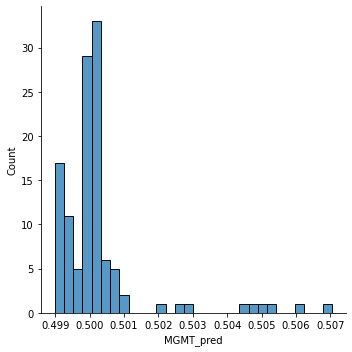

In [11]:
df_valid = df_valid.set_index('BraTS21ID')
df_valid['MGMT_pred'] = 0
for m,mtype in zip(modelfiles, mri_types):
    pred = predict(m, df_valid,mtype,'train')
    df_valid['MGMT_pred'] += pred['MGMT_value']
df_valid['MGMT_pred']/=len(modelfiles)
auc = roc_auc_score(df_valid['MGMT_value'],df_valid['MGMT_pred'])
print(f'Validtion ensemble AUC:{auc:.4f}')
sns.displot(df_valid['MGMT_pred'])

# Ensemble for submission

In [12]:
submission = pd.read_csv(f'{data_directory}/sample_submission.csv',index_col = 'BraTS21ID')
submission['MGMT_value'] = 0
for m, mtype in zip(modelfiles,mri_types):
    pred = predict(m, submission, mtype, split='test')
    submission['MGMT_value'] += pred['MGMT_value']
    
submission['MGMT_value']/=len(modelfiles)
submission['MGMT_value'].to_csv('submission.csv')

Pridict: FLAIR-e3-loss0.693-auc0.532.pth FLAIR (87, 1)
Pridict: T1w-e3-loss0.695-auc0.496.pth T1w (87, 2)
Pridict: T1wCE-e1-loss0.693-auc0.533.pth T1wCE (87, 2)
Pridict: T2w-e1-loss0.693-auc0.456.pth T2w (87, 2)


In [13]:
submission

,MGMT_value,MRI_Type
BraTS21ID,,
1,0.500222,T2w
13,0.500248,T2w
15,0.500345,T2w
27,0.498938,T2w
37,0.499640,T2w
...,...,...
826,0.500539,T2w
829,0.499171,T2w
833,0.499943,T2w


In [14]:
from IPython.display import FileLink
for modelfile in modelfiles:
    FileLink(modelfile)